In [557]:
from dataclasses import dataclass
import random
from typing import Sequence

from dg_commons import PlayerName
from dg_commons.sim import SimObservations, InitSimObservations
from dg_commons.sim.agents import Agent
from dg_commons.sim.goals import PlanningGoal
from dg_commons.sim.models.diff_drive import DiffDriveCommands
from dg_commons.sim.models.diff_drive_structures import (
    DiffDriveGeometry,
    DiffDriveParameters,
)
from dg_commons.sim.models.obstacles import StaticObstacle
import numpy as np
import matplotlib.pyplot as plt
from shapely import STRtree
from shapely import box
from shapely.geometry.base import BaseGeometry
from shapely import LineString
from shapely import LinearRing
from shapely import Point
from shapely import Polygon
from typing import Optional, TypeVar, Set, Mapping, Tuple, List
import queue
from pqdict import pqdict
import numpy as np
import matplotlib.pyplot as plt
import random
import queue
from shapely import geometry as geo
from shapely import wkt
from shapely import ops
import networkx as nx

Some Utility Function

In [558]:
def rotateZ(vec: np.array, theta: float):
    # theta in radius
    # vector dim = (2,1)
    vec = vec.reshape((2, 1))
    RoatMat = np.array(
        [[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]]
    )
    RoatMat = RoatMat.reshape((2, 2))
    return RoatMat @ vec
def vecToAngle(vec):
    if vec[0] == 0:
        if vec[1] > 0:
            return np.pi / 2
        if vec[1] < 0:
            return np.pi * (3 / 2)
    if vec[1] == 0:
        if vec[0] > 0:
            return 0
        if vec[0] < 0:
            return np.pi
    theta = np.arctan2(vec[1], vec[0])
    return theta
def angleNormalize(in_angle):
    # input: angle in rad
    # output: angle in rad in range[-pi , pi]
    if in_angle >= np.pi:
        out_angle = in_angle - 2 * np.pi
    elif in_angle <= -1 * np.pi:
        out_angle = in_angle + 2 * np.pi
    else:
        out_angle = in_angle
    return out_angle

Some Plotting Function

In [559]:
def plotPointList(ax,point_list,style='b.'):
    x_coords = [point[0] for point in point_list]  # Extract x coordinates
    y_coords = [point[1] for point in point_list]  # Extract y coordinates
    ax.plot(x_coords,y_coords,style)
    
def plotLine(ax,p1,p2,style='r-'):
    #error handle
    if isinstance(p1, np.ndarray):
        p1 = p1.flatten()
    if isinstance(p2, np.ndarray):
        p2 = p2.flatten()
    
    
    x = [p1[0],p2[0]]
    y = [p1[1],p2[1]]
    ax.plot(x,y,style)
def plotPolygon(ax, poly:Polygon):
    coord_s = poly.exterior.coords[0]
    coord_prev = coord_s
    for coord in poly.exterior.coords:
        if coord == coord_prev:
            continue
        # print("coord_prev:{0}".format(coord_prev))
        # print("coord:{0}".format(coord))
        plotLine(ax,p1=coord_prev,p2=coord)
        coord_prev = coord
        
def plot_circle(ax, center, radius,style='b'):

    # Create a circle
    circle = plt.Circle(center, radius, edgecolor=style, facecolor='none')

    # Plot the circle
    ax.add_patch(circle)

#plot robot
def plot_robot(ax, pos, psi, radius=0.6):#radius in [m], psi range[0,2*pi]
    plot_circle(ax, center=pos, radius=radius, style='k')
    x_norm = np.array([1,0])
    dir_vec = rotateZ(x_norm, psi)
    p1=pos

    plotLine(ax,p1=pos, p2=(np.array(pos).reshape(2,1) + 0.5 * dir_vec)) 
    pass

    

#calculate trajectory
class State:
    def __init__(self) -> None:
        self.pos:Tuple = None
        self.dir:float = None
        self.v:float = None
        self.w:float = None
    def plot(self,ax):
        plot_robot(ax, pos=self.pos, psi=self.dir)
        
    

def calculateTrajectory(pos_init,psi_init:float,v:float,w:float ,T:float, dt=0.1, )->List[State]:
    #Calculate the Trajectory given:
    #We assume velocity and angular velocity
    #inputs: 
    #initial position in global frame: pos_init [m]
    #initial direction in global frame: psi_init [rad][0,2pi]
    #forward velocity in robot frame: v [m/s]
    #angular velocity in robot frame: w [rad/s]
    #time horizon: T [s]
    #time resolution: dt [s]
    
    #outputs:
    #trajectory: Tra
    #-----input type handle-------
    if isinstance(pos_init, np.ndarray):
        pos_init = pos_init.flatten()
    #-----------------------------
    
    x = pos_init[0]
    y = pos_init[1]
    theta = psi_init
    
    num_steps = round(T/dt)
    
    Tra:List[State] = []
    for i in range(num_steps):
        x = x + v * dt * np.cos(theta)
        y = y + v * dt * np.sin(theta)
        theta = theta + w * dt
        
        #record the trajectory
        s = State()
        s.pos = (x,y)
        s.dir = theta
        s.v = v
        s.w = w
        Tra.append(s)
        
    return Tra

def TrajectoryToShapelyPointList(Tra:List[State])->List[Point]:
    pointList_shapely = []
    for state in Tra:
        pointList_shapely.append(Point(state.pos))
    return pointList_shapely
        
    

Test Plotting, Test Trajectory Calculation

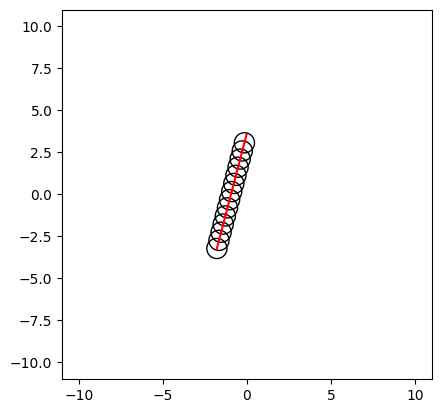

In [560]:
# Define the bounds
x_min, x_max = -11, 11
y_min, y_max = -11, 11

fig , ax = plt.subplots()
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_aspect("equal")
# pos_init = (-1.5824722801399984, -2.3335481991737574)
pos_init = (-1.787353131883869, -3.214495718295328)
psi_init = 1.3157894736842115
plot_robot(ax, pos_init, psi_init)

#test trajectory calculation
v = 5.0
w = 0.0
T = 1.3

Tra = calculateTrajectory(pos_init,psi_init,v,w,T)
for state in Tra:
    state.plot(ax)
    


Velocity sample, Trajectory Sample, and Trajectory collision detection

In [561]:
def omegaPairToVelocity(omega1:float, omega2:float):
    # Note: for per unit d_omega=omega2-omega1, the angular velocity w = 0.2 rad/s
    w = (omega2-omega1) * 0.2
    v = (omega2+omega1)/2.0
    return v,w
def velocityToOmegaPair(v:float,w:float):
    omega1 = (2*v - 5*w)/2
    omega2 = (5*w + 2*v)/2
    return omega1,omega2
#if a trajectory hit an obstacle, return True
#Note: radius of robot is 0.6m, we identified as collision if the centre to obstacle < 0.6m
#str_tree contains all the obstacles
def trajectoryCollision(Tra:List[State], str_tree:STRtree)->bool:
    pointList_shapely = TrajectoryToShapelyPointList(Tra)
    index_query, distance = str_tree.query_nearest(pointList_shapely, return_distance=True)
    if distance[distance <= 0.7].size == 0:
        #No Collision
        return False,min(distance)
    else:
        return True,0

# Evaluate every admissible trajectory and return the optimal one
# Evaluate According to:
# (1) distance of final state position to target
# (2) difference of final state heading to ideal heading
# (3) line velocity, larger is better
def normalize_array_minmax(arr:np.array):
    normalized = np.interp(arr, (arr.min(), arr.max()), (0, 1))
    return normalized
 
def scorePosition(pos_final:Tuple,pos_target:Tuple)->float:
    eps = 0.7
    dis = np.linalg.norm(np.array(pos_final)-np.array(pos_target))
    score = 1/(dis + eps)
    return score

def scoreDistanceToObstacle(d:float)->float:
    L = 1
    if d<L:
        score = d
    else:
        score = L
    return score
def scoreHeading(psi_final:float,pos_final:Tuple,pos_target:Tuple)->float:   
    vec_relative = np.array(pos_target)-np.array(pos_final)
    psi_ideal = vecToAngle(vec_relative)

    psi_error =  abs(angleNormalize(psi_final-psi_ideal))   
    score = np.pi - psi_error
    return score
def scoreVelocity(v)->float:
    score = np.abs(v)
    return score
    
      
def CalculateOptimalTrajectory(TraList_Safe:List[List[State]],TraList_Safe_dist:List[float], pos_target:Tuple)->List[State]:
    #Hyperparameter
    alpha = 1.0
    beta = 1.0
    gamma = 1.0
    eta = 1.0
    
    
    
    
    num_tra = len(TraList_Safe)
    
    scorePositionArr:np.array = np.zeros(num_tra)
    scoreHeadingArr:np.array =  np.zeros(num_tra)
    scoreVelocityArr:np.array = np.zeros(num_tra)
    scoreDistanceArr:np.array = np.zeros(num_tra)
    
    for i in range(num_tra):
        Tra = TraList_Safe[i]
        s_final = Tra[-1]
        pos_final = s_final.pos
        psi_final = s_final.dir
        v = s_final.v
        
        scorePositionArr[i] = scorePosition(pos_final,pos_target)
        scoreHeadingArr[i] = scoreHeading(psi_final,pos_final,pos_target)
        scoreVelocityArr[i] = scoreVelocity(v)
        scoreDistanceArr[i] = scoreDistanceToObstacle(TraList_Safe_dist[i])
        
    #Normalize Each Score Array
    print("[Debug]num_tra:{0}".format(num_tra))
    scorePositionArr_normalized = normalize_array_minmax(scorePositionArr)
    scoreHeadingArr_normalized =  normalize_array_minmax(scoreHeadingArr)
    scoreVelocityArr_normalized = normalize_array_minmax(scoreVelocityArr)   
    scoreDistArr_normalized = normalize_array_minmax(scoreDistanceArr)
        
    #calculate the final score
    scoreArr = alpha * scorePositionArr_normalized + beta * scoreHeadingArr_normalized + gamma * scoreVelocityArr_normalized + eta * scoreDistArr_normalized
      
    index_max = np.argmax(scoreArr) 
    print("scorePositionArr_normalized[index_max]:{0}".format(scorePositionArr_normalized[index_max]))
    print("scoreDistArr_normalized[index_max]:{0}".format(scoreDistArr_normalized[index_max]))
    print("scoreHeadingArr_normalized[index_max]:{0}".format(scoreHeadingArr_normalized[index_max]))
    print("scoreVelocityArr_normalized[index_max]:{0}".format(scoreVelocityArr_normalized[index_max]))
    return TraList_Safe[index_max] 
        
        
        
    
    
        

Velocity Samples

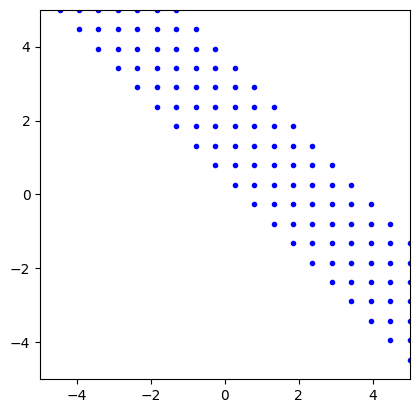

In [562]:
# the limit on each omega is[-5,5]

resolution = 20
num_point = resolution**2
# Define the ranges for x and y
x_range = np.linspace(-5, 5, resolution)  # Adjust the number of points as needed
y_range = np.linspace(-5, 5, resolution)  # Adjust the number of points as needed

# Create a grid of points
x, y = np.meshgrid(x_range, y_range)

# Flatten the grid to get a list of points
points = np.column_stack((x.flatten(), y.flatten()))

# we only filter out velocity that violate acceleration constrain

#--------------define current velocity------------
v_cur = 1.0526315789473681
w_cur = -0.105263157894737


#define acceleration constrain
dt = 0.1
v_dot_up = 10 #the upper bound on line acceleration i.e. maximum acceleration
v_dot_low = 10 #the lower bound on line acceleration i.e. maximum deceleration
w_dot_up = 20 #the upper bound on angular acceleration i.e. maximum acceleration
w_dot_low = 20 #the lower bound on angular acceleration i.e. maximum acceleration
velocity_points = []
for point in points:
    omega1 = point[0]
    omega2 = point[1]
    v,w = omegaPairToVelocity(omega1, omega2)
    
    if(v_cur-v_dot_low*dt<=v and v<=v_cur+v_dot_up*dt and w_cur-w_dot_low*dt<=w and w<=w_cur+w_dot_up*dt):
        velocity_points.append(point)
    
x_min, x_max = -5, 5
y_min, y_max = -5, 5

fig , ax = plt.subplots()
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_aspect("equal")
plotPointList(ax,point_list=velocity_points)

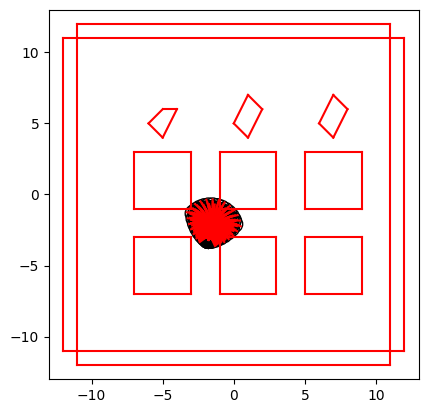

In [563]:


# Define the bounds
x_min, x_max = -13, 13
y_min, y_max = -13, 13

fig , ax = plt.subplots()
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_aspect("equal")

#Define Obstacles
polygons = []
coords1 = ((-11, -11), (11, -11), (11, -12), (-11, -12))  # lower edge
polygons.append(Polygon(coords1))
coords2 = ((-11, 11), (11, 11), (11, 12), (-11, 12))  # upper edge
polygons.append(Polygon(coords2))
coords3 = ((-11, -11), (-11, 11), (-12, 11), (-12, -11))  # left edge
polygons.append(Polygon(coords3))
coords4 = ((11, -11), (11, 11), (12, 11), (12, -11))  # right edge
polygons.append(Polygon(coords4))

coords1 = ((-7, -7), (-7, -3), (-3, -3), (-3, -7), (-7, -7))
polygons.append(Polygon(coords1))
coords2 = ((-1, -7), (-1, -3), (3, -3), (3, -7), (-1, -7))#
polygons.append(Polygon(coords2))
coords3 = ((5, -7), (5, -3), (9, -3), (9, -7), (5, -7))#
polygons.append(Polygon(coords3))
coords4 = ((-7, -1), (-7, 3), (-3, 3), (-3, -1), (-7, -1))
polygons.append(Polygon(coords4))
coords5 = ((-1, -1), (-1, 3), (3, 3), (3, -1), (-1, -1))#
polygons.append(Polygon(coords5))
coords6 = ((5, -1), (5, 3), (9, 3), (9, -1), (5, -1))#
polygons.append(Polygon(coords6))
coords7 = ((-6, 5), (-5, 6), (-4, 6), (-5, 4), (-6, 5))#
polygons.append(Polygon(coords7))
coords8 = ((0, 5), (1, 7), (2, 6), (1, 4), (0, 5))
polygons.append(Polygon(coords8))
coords9 = ((6, 5), (7, 7), (8, 6), (7, 4), (6, 5))#
polygons.append(Polygon(coords9))
for poly in polygons:
    plotPolygon(ax,poly)
tree = STRtree(polygons)



TraList_Safe: List[List[State]] = []

for i in range(len(velocity_points)):
        omega1 = velocity_points[i][0]
        omega2 = velocity_points[i][1]
        v,w = omegaPairToVelocity(omega1, omega2)
        Tra = calculateTrajectory(pos_init,psi_init,v,w,T)
        # If there is collision , we abandom this trajectory
        collision_flag,dis = trajectoryCollision(Tra,str_tree=tree)
        #-------visualization----
        for state in Tra:
            state.plot(ax)
        if(not collision_flag):
            #If no collision, we add it to TraList_Safe
            TraList_Safe.append(Tra)

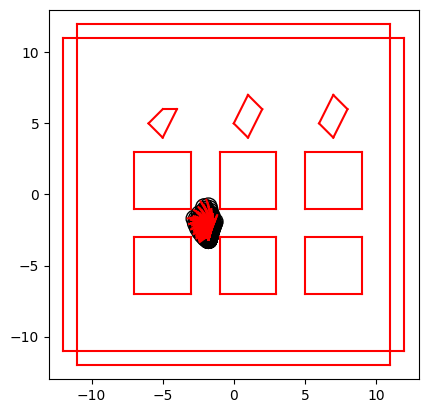

In [564]:


# Define the bounds
x_min, x_max = -13, 13
y_min, y_max = -13, 13

fig , ax = plt.subplots()
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_aspect("equal")

#Define Obstacles
polygons = []
coords1 = ((-11, -11), (11, -11), (11, -12), (-11, -12))  # lower edge
polygons.append(Polygon(coords1))
coords2 = ((-11, 11), (11, 11), (11, 12), (-11, 12))  # upper edge
polygons.append(Polygon(coords2))
coords3 = ((-11, -11), (-11, 11), (-12, 11), (-12, -11))  # left edge
polygons.append(Polygon(coords3))
coords4 = ((11, -11), (11, 11), (12, 11), (12, -11))  # right edge
polygons.append(Polygon(coords4))

coords1 = ((-7, -7), (-7, -3), (-3, -3), (-3, -7), (-7, -7))
polygons.append(Polygon(coords1))
coords2 = ((-1, -7), (-1, -3), (3, -3), (3, -7), (-1, -7))#
polygons.append(Polygon(coords2))
coords3 = ((5, -7), (5, -3), (9, -3), (9, -7), (5, -7))#
polygons.append(Polygon(coords3))
coords4 = ((-7, -1), (-7, 3), (-3, 3), (-3, -1), (-7, -1))
polygons.append(Polygon(coords4))
coords5 = ((-1, -1), (-1, 3), (3, 3), (3, -1), (-1, -1))#
polygons.append(Polygon(coords5))
coords6 = ((5, -1), (5, 3), (9, 3), (9, -1), (5, -1))#
polygons.append(Polygon(coords6))
coords7 = ((-6, 5), (-5, 6), (-4, 6), (-5, 4), (-6, 5))#
polygons.append(Polygon(coords7))
coords8 = ((0, 5), (1, 7), (2, 6), (1, 4), (0, 5))
polygons.append(Polygon(coords8))
coords9 = ((6, 5), (7, 7), (8, 6), (7, 4), (6, 5))#
polygons.append(Polygon(coords9))
for poly in polygons:
    plotPolygon(ax,poly)
tree = STRtree(polygons)



TraList_Safe: List[List[State]] = []
TraList_Safe_dist:List[float] = []
for i in range(len(velocity_points)):
        omega1 = velocity_points[i][0]
        omega2 = velocity_points[i][1]
        v,w = omegaPairToVelocity(omega1, omega2)
        Tra = calculateTrajectory(pos_init,psi_init,v,w,T)
        # If there is collision , we abandom this trajectory
        collision_flag,dis = trajectoryCollision(Tra,str_tree=tree)
        if(not collision_flag):
            #-------visualization----
            for state in Tra:
                state.plot(ax)
            #If no collision, we add it to TraList_Safe
            TraList_Safe.append(Tra)
            TraList_Safe_dist.append(dis)
            
 

Test Calculate the optimal trajectory

[Debug]num_tra:50
scorePositionArr_normalized[index_max]:1.0
scoreDistArr_normalized[index_max]:0.0
scoreHeadingArr_normalized[index_max]:0.8596757160666192
scoreVelocityArr_normalized[index_max]:0.5000000000000001
omega1_opti:1.3157894736842106 ; omega2_opti:0.7894736842105257


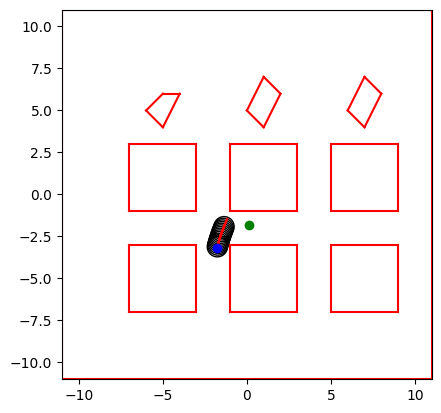

In [565]:
# Define the bounds
x_min, x_max = -11, 11
y_min, y_max = -11, 11

fig , ax = plt.subplots()
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_aspect("equal")

#Define Obstacles
for poly in polygons:
    plotPolygon(ax,poly)
    
#Calculate the Optimal Trajectory
pos_target = (0.0966796875, -1.8157293095564686)
Tra_optimal = CalculateOptimalTrajectory(TraList_Safe,TraList_Safe_dist ,pos_target)
v_opti = Tra_optimal[0].v
w_opti = Tra_optimal[0].w
omega1_opti,omega2_opti = velocityToOmegaPair(v=v_opti,w=w_opti)
#-------visualization----
for state in Tra_optimal:
    state.plot(ax)
plotPointList(ax,[pos_init],"bo")
plotPointList(ax,[pos_target],"go")
print("omega1_opti:{0} ; omega2_opti:{1}".format(omega1_opti,omega2_opti))


Collision test

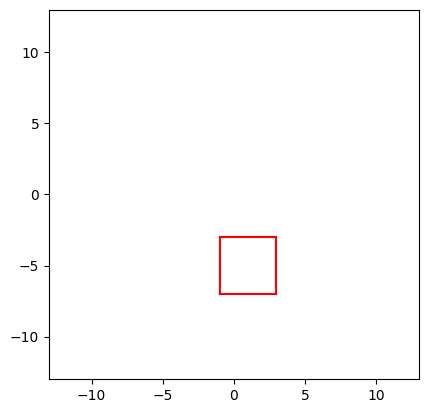

In [566]:
# Define the bounds
x_min, x_max = -13, 13
y_min, y_max = -13, 13

fig , ax = plt.subplots()
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_aspect("equal")

polygons = []
coords2 = ((-1, -7), (-1, -3), (3, -3), (3, -7), (-1, -7))#
polygons.append(Polygon(coords2))
for poly in polygons:
    plotPolygon(ax,poly)
tree = STRtree(polygons)

# index_query, distance = str_tree.query_nearest(pointList_shapely, return_distance=True)